In [9]:
import torch
from torch import tensor
from torch.types import Tensor
from math import *

# Disable JIT compiler and profiling for better debugging
# torch._C._jit_set_profiling_executor(False)
# torch._C._jit_set_profiling_mode(False)
# torch.jit._state.disable()


# Refactoring Goals
- Remove confusion between numpy and torch vectorisations
- Use builtin maths for scalars
- Use torch.tensor for everything else
- Tighten up the data type headaches
- Remove sliding NSGT support
- De-crustify the legacy code
- Make the pytorch code more idiomatic



In [10]:
class Scale:
    dbnd = 1.e-8
    F : Tensor = None
    Q : Tensor = None

    def F_by_bnd(self, bnd_index: Tensor):
        return self.F[bnd_index]
    
    def Q_by_bnd(self, bnd_index: Tensor):
        return self.Q[bnd_index]

    def __init__(self, bnds):
        self.bnds = bnds

    def __len__(self):
        return self.bnds

class OctScale(Scale):
    def __init__(self, bpo, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bpo: bands per octave (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        lfmin = log2(fmin)
        lfmax = log2(fmax)
        bnds = int(ceil((lfmax-lfmin)*bpo))+1
        Scale.__init__(self, bnds+beyond*2)
        odiv = (lfmax-lfmin)/(bnds-1)
        lfmin_ = lfmin-odiv*beyond
        lfmax_ = lfmax+odiv*beyond
        self.fmin = 2**lfmin_
        self.fmax = 2**lfmax_
        self.pow2n = 2**odiv
        q = sqrt(self.pow2n)/(self.pow2n-1.)/2.

        self.Q = tensor([q])
        self.F = self.fmin*self.pow2n**torch.arange(self.bnds)



class LinScale(Scale):
    def __init__(self,  bnds, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        self.df = float(fmax-fmin)/(bnds-1)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)-self.df*beyond
        if self.fmin <= 0:
            raise ValueError("Frequencies must be > 0.")
        self.fmax = float(fmax)+self.df*beyond
        self.F = torch.arange(self.bnds)*self.df+self.fmin
        self.Q = self.F / (self.df*2)


def hz2mel(f):
    "\\cite{shannon:2003}"
    if isinstance(f, Tensor):
        return torch.log10(f/700.+1.)*2595.
    else:
        return log10(f/700.+1.)*2595


def mel2hz(m):
    "\\cite{shannon:2003}"
    return (10.0**(m/2595.)-1)*700


class MelScale(Scale):
    def __init__(self, bnds, fmin, fmax, beyond=0):
        """
        @param fmin: minimum frequency (Hz)
        @param fmax: maximum frequency (Hz)
        @param bnds: number of frequency bands (int)
        @param beyond: number of frequency bands below fmin and above fmax (int)
        """
        mmin = hz2mel(fmin)
        mmax = hz2mel(fmax)
        Scale.__init__(self, bnds+beyond*2)
        self.fmin = float(fmin)
        self.fmax = float(fmax)
        self.mbnd = (mmax-mmin)/(bnds-1)  # mels per band
        self.mmin = mmin-self.mbnd*beyond
        self.mmax = mmax+self.mbnd*beyond

        mels = torch.arange(bnds) * self.mbnd + self.mmin

        self.F = mel2hz(mels)

        odivs = (torch.exp(mels/-1127.)-1.) * (-781.177/self.mbnd)
        pow2n = 2.0 ** (1./odivs)
        self.Q = pow2n.sqrt()/ (pow2n-1.)/2.
    


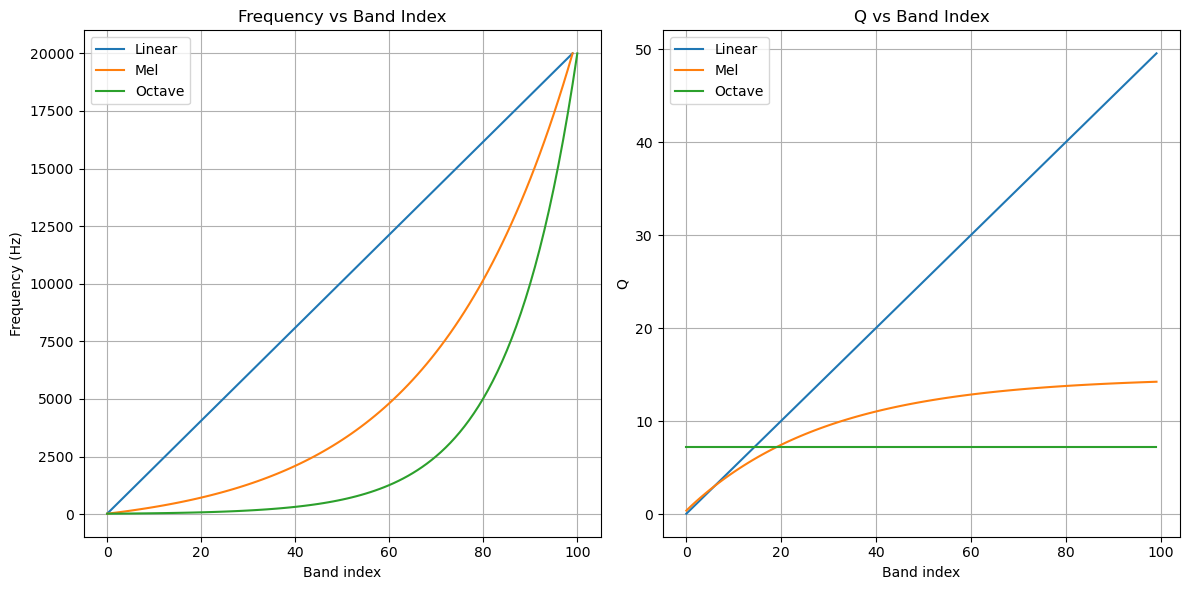

In [11]:
import matplotlib.pyplot as plt

# Create example scales
lin_scale = LinScale(100, 20, 20000)
mel_scale = MelScale(100, 20, 20000)
oct_scale = OctScale(10,  20, 20000)

# Plot frequency scales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lin_scale.F, label='Linear')
plt.plot(mel_scale.F, label='Mel')
plt.plot(oct_scale.F, label='Octave')
plt.xlabel('Band index')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency vs Band Index')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lin_scale.Q, label='Linear')
plt.plot(mel_scale.Q, label='Mel')
plt.plot(oct_scale.Q.repeat(100), label='Octave')
plt.xlabel('Band index')
plt.ylabel('Q')
plt.title('Q vs Band Index')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


In [12]:
def hannwin(l):
    r = torch.arange(l,dtype=float)
    r *= torch.pi*2./l
    r = torch.cos(r)
    r += 1.
    r *= 0.5
    return r



In [13]:
from warnings import warn

"""
Thomas Grill, 2011-2015
http://grrrr.org/nsgt

--
        Original matlab code comments follow:

NSGFWIN.M
---------------------------------------------------------------
 [g,rfbas,M]=nsgfwin(fmin,bins,sr,Ls) creates a set of windows whose
 centers correspond to center frequencies to be
 used for the nonstationary Gabor transform with varying Q-factor. 
---------------------------------------------------------------

INPUT : fmin ...... Minimum frequency (in Hz)
        bins ...... Vector consisting of the number of bins per octave
        sr ........ Sampling rate (in Hz)
        Ls ........ Length of signal (in samples)

OUTPUT : g ......... Cell array of window functions.
         rfbas ..... Vector of positions of the center frequencies.
         M ......... Vector of lengths of the window functions.

AUTHOR(s) : Monika Dörfler, Gino Angelo Velasco, Nicki Holighaus, 2010

COPYRIGHT : (c) NUHAG, Dept.Math., University of Vienna, AUSTRIA
http://nuhag.eu/
Permission is granted to modify and re-distribute this
code in any manner as long as this notice is preserved.
All standard disclaimers apply.

EXTERNALS : firwin
"""

def nsgfwin(f : Tensor, q: Tensor, sr, Ls, min_win=4, do_warn=True, dtype=torch.float64) -> tuple[list, Tensor, Tensor]:
    """
    f: list of center frequencies
    q: list of Q-factors
    sr: sampling rate
    Ls: length of signal
    min_win: minimum window length

    Returns:
        g: list of window functions
        rfbas: list of center frequencies
        M: list of window lengths
    """

    nyquist_f = sr/2.0

    mask = f > 0
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly <= 0 
        f = f[lim:]
        q = q[lim:]
            
    mask = f >= nyquist_f
    lim = torch.argmax(mask.int())
    if mask.any():
        # f partly >= nf 
        f = f[:lim]
        q = q[:lim]
    
    # assert len(f) == len(q)
    assert torch.all((f[1:]-f[:-1]) > 0)  # frequencies must be monotonic
    assert torch.all(q > 0)  # all q must be > 0
    
    qneeded = f*(Ls/(8.*sr))
    if torch.any(q >= qneeded) and do_warn:
        warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))
    
    fbas : Tensor[int] = f
    lbas : int = len(fbas)
    frqs = torch.concatenate([
        tensor([0.0])
        ,f,
        tensor([nyquist_f])
    ])
    fbas = torch.concatenate([frqs, tensor([sr]) - torch.flip(f, (0,))])

    fbas *= float(Ls)/sr

    M : Tensor = torch.zeros(fbas.shape, dtype=int)

    M[0] = torch.round(2*fbas[1])
    for k in range(1,2*lbas+1):
        M[k] = torch.round(fbas[k+1]-fbas[k-1])
    M[-1] = torch.round(Ls-fbas[-2])

    M = torch.clip(M, min_win, torch.inf)

    g : list = [hannwin(m) for m in M]

    fbas[lbas] = (fbas[lbas-1]+fbas[lbas+1])/2
    fbas[lbas+2] = Ls-fbas[lbas]
    rfbas = torch.round(fbas).to(int)

    return g, rfbas, M


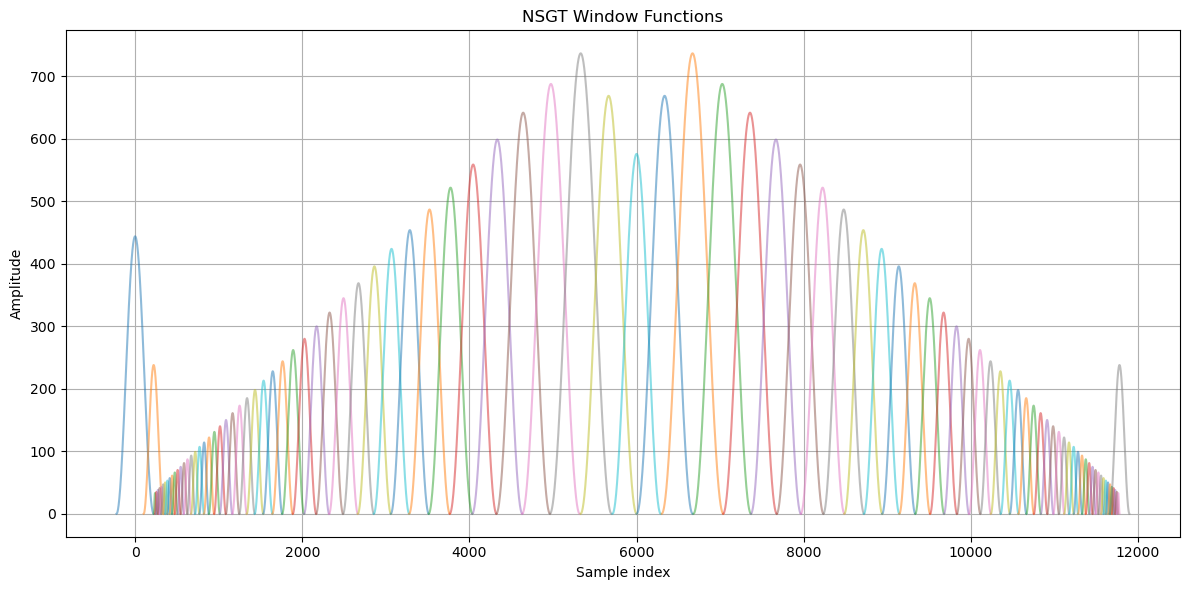

In [14]:
f = oct_scale.F
q = oct_scale.Q

sr = 1080
Ls = 12000

g, rfbas, M = nsgfwin(f,q,sr,Ls)

def plot_nsgfwin_results(g, rfbas, M):
    fig, ax = plt.subplots(figsize=(12,6))
    
    # Plot each window function
    for i, window in enumerate(g):
        # Center each window at its frequency position
        center = rfbas[i]
        x = torch.arange(len(window)) + center - len(window)//2
        ax.plot(x, M[i]- window * M[i], alpha=0.5, label=f'Window {i}')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Amplitude') 
    ax.set_title('NSGT Window Functions')
    ax.grid(True)
    
    # Only show legend if there aren't too many windows
    if len(g) <= 10:
        ax.legend()
        
    plt.tight_layout()
    return fig

# Test the plotting function
f = plot_nsgfwin_results(g, rfbas, M)

NN:  12000


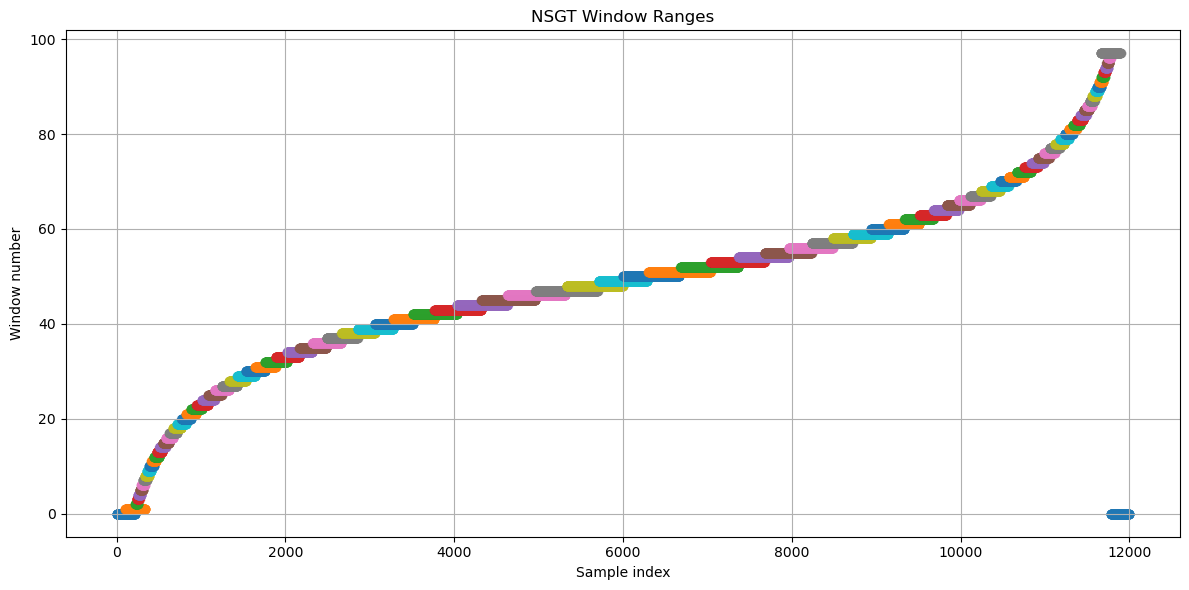

In [26]:
def calcwinrange(g : list, rfbas : Tensor, Ls : int) -> tuple[list[Tensor], int]:
    shift = torch.concatenate([
        (-rfbas[-1] % Ls).unsqueeze(0), 
        rfbas[1:]-rfbas[:-1]
    ])
    
    timepos = torch.cumsum(shift, 0)
    nn = int(timepos[-1].item())
    timepos -= shift[0] # Calculate positions from shift vector
    
    wins = []
    for gii,tpii in zip(g, timepos):
        Lg = len(gii)
        win_range = torch.arange(-(Lg//2)+tpii, Lg-(Lg//2)+tpii, dtype=int)
        win_range %= nn

        wins.append(win_range)
        
    return wins,nn


#================

# Plot the window ranges
wins, nn = calcwinrange(g, rfbas, Ls)

print ("NN: ", nn)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each window range as a scatter plot
for i, win_range in enumerate(wins):
    ax.scatter(win_range.cpu(), [i] * len(win_range), alpha=0.5, label=f'Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Window number')
ax.set_title('NSGT Window Ranges')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(wins) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


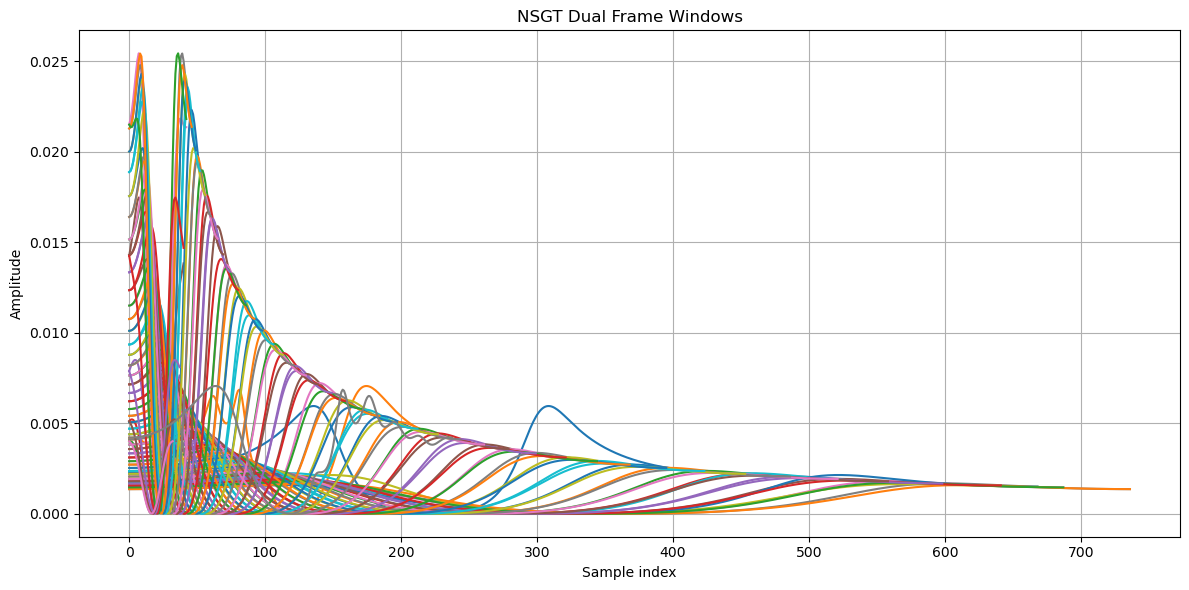

In [16]:
def nsdual(g: list[Tensor], wins: list[Tensor], nn: Tensor, M: list[int]) -> list[Tensor]:
    # Construct the diagonal of the frame operator matrix explicitly
    x = torch.zeros(nn, dtype=float)
    for gi,mii,sl in zip(g, M, wins):
        xa = torch.square(torch.fft.fftshift(gi))
        xa *= mii

        x[sl] += xa

    gd = [gi/torch.fft.ifftshift(x[wi]) for gi,wi in zip(g,wins)]
    return gd

# Calculate dual frame
dual_frame = nsdual(g, wins, nn, M)

# Plot the dual frame
fig, ax = plt.subplots(figsize=(12, 6))

for i, gd in enumerate(dual_frame):
    ax.plot(gd.cpu(), label=f'Dual Window {i}')

ax.set_xlabel('Sample index')
ax.set_ylabel('Amplitude')
ax.set_title('NSGT Dual Frame Windows')
ax.grid(True)

# Only show legend if there aren't too many windows
if len(dual_frame) <= 10:
    ax.legend()
    
plt.tight_layout()
plt.show()


# [win.shape[0] for win in dual_frame]


In [17]:
def n_coefs(M: Tensor, g: list[Tensor], sl: slice)->int:
    return int(max(int(ceil(float(len(gii))/mii))*mii for mii,gii in zip(M[sl],g[sl])).item())

n_coefs(M, g, slice(0,50))

737

In [31]:
def nsgtf(
        f: Tensor,
        g: list[Tensor],
        wins: list[Tensor],
        nn: int, M: Tensor,
        reducedform: int
    ) -> Tensor[torch.complex]:
    """
    Compute the Non-Stationary Gabor Transform (NSGT) of the input signal.

    This function applies the fast Fourier transform (FFT) to the input signal to convert it into the
    frequency domain. It then processes each frequency slice by multiplying with a corresponding analysis
    window (after necessary padding and FFT shift) and finally applies an inverse FFT to obtain the
    NSGT coefficients representing the signal in the time-frequency domain.

    Parameters:
        f (Tensor): Input signal tensor of shape (channel, signal_length) representing time-domain data.
        g (list[Tensor]): List of analysis window tensors.
        wins (list[Tensor]): List of window ranges (or index arrays) specifying the frequency bins to process for each window.
        nn (int): Total number of samples in the input signal (should match f's last dimension).
        M (Tensor): Tensor containing modulation parameters (e.g., window lengths or hop sizes) for each analysis window.
        reducedform (int): Specifies the level of frequency reduction for real signals (valid values are typically 0, 1, or 2).

    Returns:
        Tensor: 

    Notes:
        - Each analysis window in g is padded to a uniform length based on the maximum number of coefficients required.
        - An FFT shift is applied to the windowed data prior to the inverse FFT to ensure proper alignment.
    """

    fft : function = torch.fft.fft
    ifft : function = torch.fft.ifft

    assert 0 <= reducedform <= 2
    sl = slice(reducedform,len(g)//2+1-reducedform)

    maxLg = n_coefs(M, g, sl)

    loopparams = []
    for mii, gii, win_range in zip(M[sl],g[sl],wins[sl]):
        Lg = len(gii)
        col = int(ceil(float(Lg)/mii))
        assert col*mii >= Lg
        assert col == 1

        p = (mii,win_range,Lg,col)
        loopparams.append(p)

    ragged_giis = [
        torch.nn.functional.pad(
            torch.unsqueeze(gii, dim=0), (0, maxLg-gii.shape[0])
        )
            for gii in g[sl]
    ]
    giis = torch.conj(torch.cat(ragged_giis))

    ft = fft(f)

    Ls = f.shape[-1]

    assert nn == Ls

    c = torch.zeros(f.shape[0], len(loopparams), maxLg, dtype=ft.dtype)

    for j, (mii,win_range,Lg,col) in enumerate(loopparams):
        t = ft[:, win_range]*torch.fft.fftshift(giis[j, :Lg])

        sl1 = slice(None,(Lg+1)//2)
        sl2 = slice(-(Lg//2),None)

        c[:, j, sl1] = t[:, Lg//2:]  # if mii is odd, this is of length mii-mii//2
        c[:, j, sl2] = t[:, :Lg//2]  # if mii is odd, this is of length mii//2

    return ifft(c)

from itertools import chain

def nsigtf(
        c: Tensor,
        gd: list[Tensor],
        wins: list[Tensor],
        nn: int,
        Ls: int,
        reducedform: int
    ) -> Tensor:
    fft : function = torch.fft.fft
    ifft : function = torch.fft.irfft

    ln = len(gd) // 2+1 - reducedform *2
    if reducedform:
        sl = lambda x: chain(
            x[reducedform            : len(gd)//2+1-reducedform],
            x[len(gd)//2+reducedform :    len(gd)+1-reducedform]
        )
    else:
        ln = len(gd)
        sl = lambda x: x
    
    maxLg = max(len(gdii) for gdii in sl(gd))

    ragged_gdiis = [
        torch.nn.functional.pad(
            torch.unsqueeze(gdii, dim=0), (0, maxLg-gdii.shape[0])
        )
              for gdii in sl(gd)
    ]
    gdiis = torch.conj(torch.cat(ragged_gdiis))

    assert type(c) == torch.Tensor
    c_shape = c.shape[:3]
    c_dtype = c.dtype
    fc = fft(c)

    fr = torch.zeros(*c_shape[:2], nn, dtype=c_dtype)  # Allocate output
    temp0 = torch.empty(*c_shape[:2], maxLg, dtype=fr.dtype)  # pre-allocation

    fbins = c_shape[2]

    loopparams = []
    for gdii,win_range in zip(sl(gd), sl(wins)):
        Lg = len(gdii)
        wr1 = win_range[:(Lg)//2]
        wr2 = win_range[-((Lg+1)//2):]
        p = (wr1,wr2,Lg)
        loopparams.append(p)

    # Overlapp-add procedure
    for i,(wr1,wr2,Lg) in enumerate(loopparams[:fbins]):
        t = fc[:, :, i]

        r = (Lg+1)//2
        l = (Lg//2)

        t1 = temp0[:, :, :r]
        t2 = temp0[:, :, Lg-l:Lg]

        t1[:, :, :] = t[:, :, :r]
        t2[:, :, :] = t[:, :, maxLg-l:maxLg]

        temp0[:, :, :Lg] *= gdiis[i, :Lg] 
        temp0[:, :, :Lg] *= maxLg

        fr[:, :, wr1] += t2
        fr[:, :, wr2] += t1

    ftr = fr[:, :, :nn//2+1]
    sig = ifft(ftr, outn=nn)
    sig = sig[:, :, :Ls] # Truncate the signal to original length (if given)
    return sig


# Wrapping into a convenient object format

torch.Size([2, 1837349])


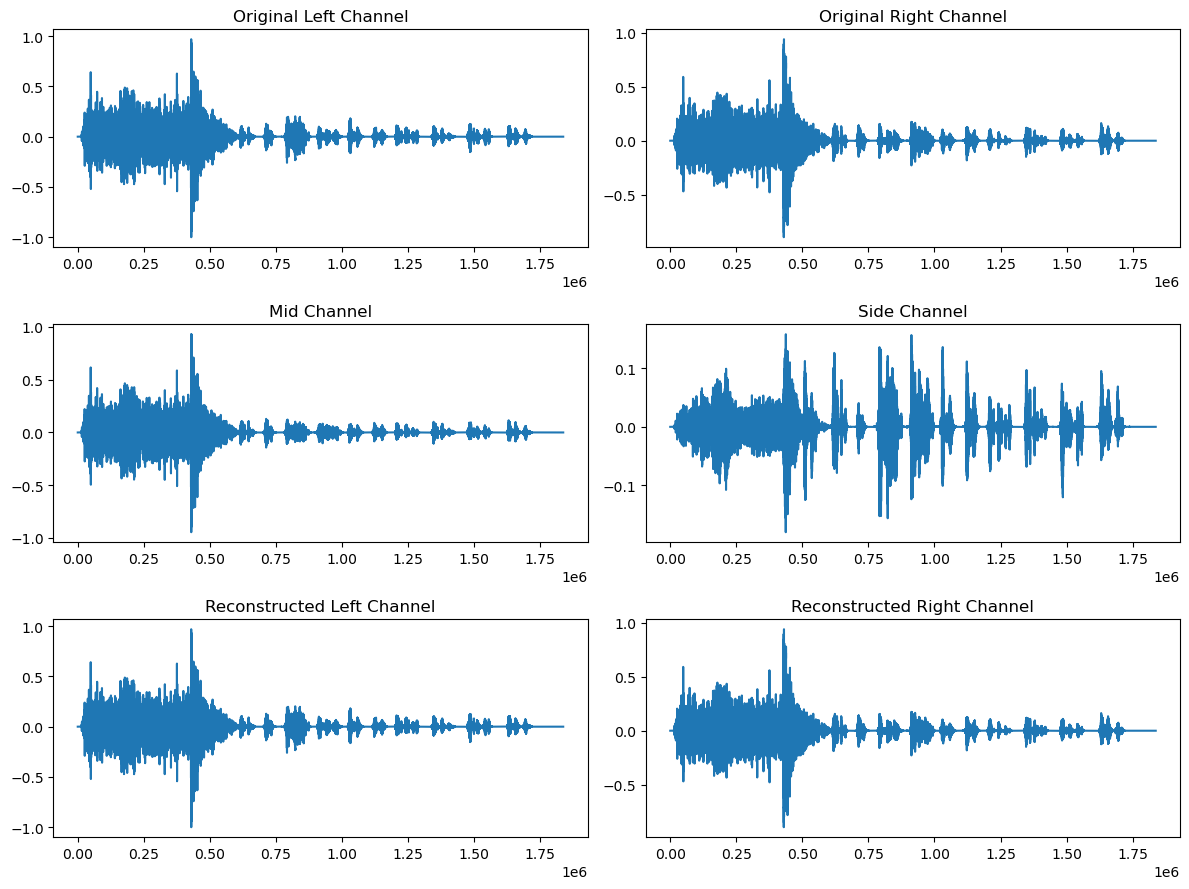

Reconstruction error: 0.0


In [53]:
def mid_side(lr_s: Tensor) -> Tensor:
    """Convert left-right stereo signal to mid-side encoding.
    
    Args:
        lr_s: Tensor of shape [2, length] containing left and right channels
        
    Returns:
        Tensor of shape [2, length] containing mid and side channels
    """
    # Check input dimensions
    assert lr_s.shape[0] == 2, "Input must be stereo (2 channels)"
    
    # Extract left and right channels
    L, R = lr_s
    
    # Calculate mid (average of left and right) and side (difference between left and right)
    mid = (L + R) / 2
    side = (L - R) / 2
    
    # Stack mid and side channels
    return torch.stack([mid, side], dim=0)


def left_right(ms_s: Tensor) -> Tensor:
    """Convert mid-side stereo signal to left-right encoding.
    
    Args:
        ms_s: Tensor of shape [2, length] containing mid and side channels
        
    Returns:
        Tensor of shape [2, length] containing left and right channels
    """
    # Check input dimensions
    assert ms_s.shape[0] == 2, "Input must be stereo (2 channels)"
    
    # Extract mid and side channels
    mid, side = ms_s
    
    # Calculate left (mid + side) and right (mid - side)
    left = mid + side
    right = mid - side
    
    # Stack left and right channels
    return torch.stack([left, right], dim=0)




In [ ]:
import torchaudio as ta

from dataclasses import dataclass, field
from tifffile import imread, imwrite

@dataclass
class GaborSystem:
    scale: Scale
    fs: int
    Ls: int
    
    ncoefs: int
    nn : int
    reducedform: int

    M: Tensor
    g: list[Tensor]
    gd: list[Tensor]

    wins: list[Tensor]

@dataclass
class GaborData:
    GS: GaborSystem

    c: Tensor
    s: Tensor

@dataclass
class GaborData:
    sourcefile: str

    GS: GaborSystem
    
    c: Tensor = None
    s: Tensor = None

    midside: bool = False
    
    @classmethod
    def from_wav(cls, filename: str, scale = OctScale(
                bpo = 24, fmin = 30, fmax = 22000
    ), reducedform = 0):
        raw, fs = ta.load(filename)
        Ls = raw.shape[-1]
        if raw.shape[0] > 1:
            s = mid_side(raw)
        else:
            s = raw

        g, rfbas, M = nsgfwin(scale.F, scale.Q, fs, Ls)

        assert 0 <= reducedform <= 2
        sl = slice(reducedform,len(g)//2+1-reducedform)

        _n_coefs = n_coefs(M, g, sl)

        wins, nn = calcwinrange(g, rfbas, Ls)

        gd = nsdual(g, wins, nn, M)

        # Set up the Gabor system
        GS = GaborSystem(scale, fs, Ls, _n_coefs, nn, reducedform, M, g, gd, wins)
        
        # Forward transform
        c = nsgtf(s, g, wins, nn, M, reducedform)
        
        return cls(filename, GS, c, s)

    def to_wav(self, filename: str):
        # Save as WAV file using torchaudio
        ta.save(filename, self.s, self.GS.fs)
        return filename
    
    def to_tiff(self, filename: str):
        pass


    def to_rgb_polar(self) -> Tensor:
        pass

    def ambisonic_rgb(self) -> Tensor:
        pass

    def plot(self):
        def spectrogram(x, ax, title, cmap='viridis', n_labels=4):
            im = ax.imshow(x.squeeze(), origin='lower', aspect='auto', cmap=cmap)
            ax.set_title(title)
            ax.set_ylabel('Frequency (Hz)')
            ax.set_yticks(range(len(self.GS.scale.F)))
            step = len(self.GS.scale.F) // (n_labels - 1)
            indices = list(range(0, len(self.GS.scale.F), step))[:n_labels]
            labels = [f'{self.GS.scale.F[i]:.0f}' if i in indices else '' for i in range(len(self.GS.scale.F))]
            ax.set_yticklabels(labels)

        """
        Plot the L/R spectrogram planes and waveform in 3 rows
        """
        fig, axes = plt.subplots(5, 1, figsize=(12, 9))
        
        # Get magnitude in dB
        c_mag = torch.abs(self.c)
        c_db = 20 * torch.log10(c_mag + 1e-6)
        
        # Get phase
        c_phase = torch.angle(self.c)
        
        # If stereo, split into left and right channels
        if len(c_db.shape) > 2 and c_db.shape[0] > 1:
            # Left channel magnitude spectrogram
            spectrogram(c_db[0], axes[0], 'Mid Channel Magnitude Spectrogram (dB)', cmap='viridis')
            
            # Left channel phase spectrogram
            spectrogram(c_phase[0], axes[1], 'Mid Channel Phase Spectrogram', cmap='hsv')
            
            # Right channel magnitude spectrogram
            spectrogram(c_db[1] - c_db[0], axes[2], 'Side Channel ILD Magnitude Spectrogram (dB)', cmap='viridis')
            
            # Right channel phase spectrogram
            spectrogram(c_phase[1] - c_phase[0], axes[3], 'Side Channel IPD', cmap='hsv')

        else:
            # Mono spectrogram (use first two plots for different visualizations)
            spectrogram(c_db, axes[0], 'Magnitude Spectrogram (dB)', cmap='viridis')
            
            # Phase plot for mono
            phase = torch.angle(self.c)
            spectrogram(phase, axes[1], 'Phase Spectrogram', cmap='hsv')
        
        # Plot the waveform
        time = torch.arange(self.s.shape[-1]) / self.GS.fs
        if len(self.s.shape) > 1 and self.s.shape[0] > 1:
            # Stereo waveform
            axes[4].plot(time, self.s[0], alpha=0.7, label='Mid')
            axes[4].plot(time, self.s[1], alpha=0.7, label='Side')
            axes[4].legend()
        else:
            # Mono waveform
            axes[4].plot(time, self.s.squeeze())
        
        axes[4].set_title('Waveform')
        axes[4].set_xlabel('Time (s)')
        axes[4].set_ylabel('Amplitude')
        
        plt.tight_layout()
        return fig, axes




guitar_example = GaborData.from_wav("spatial audio.wav")
guitar_example.plot();

IndexError: index 5 is out of bounds for axis 0 with size 5


# Phase Encoding


## Human Perception:

   - Low Frequencies (<1.5 kHz): ITD and IPD both work, but ITD is the brain’s focus. Phase matters here because cycles are long enough to avoid wrapping (e.g., 1 ms = 360° at 1000 Hz).
   - High Frequencies (>1.5 kHz): ITD weakens (head shadowing dominates), and phase becomes unreliable due to wrapping. Interaural level difference (ILD) takes over, with phase contributing to subtle spectral cues.
   - Evidence: Studies (e.g., Wightman & Kistler, 1992) show ITD dominates azimuth perception, with phase secondary unless analyzing interference.


1. **Encode the Relative (Inter­Channel) Phase**

   For many stereo applications, the relative phase (or phase difference) is what really matters (e.g., for spatial cues). In this strategy, you would do the following:

   **Compute the Difference:**  
   Let ϕₗ be the left phase and ϕᵣ be the right phase. Compute the wrapped phase difference:

   $
   Δϕ = (ϕᵣ − ϕₗ + π) mod 2π − π
   $

   **Normalize:**  
   Map Δϕ into a unit range (e.g., [0, 1]) by using:

   $
   phase_norm = (Δϕ + π) / (2π)
   $

   This single scalar per atom encodes the spatial (differential) phase information. Note that you lose the absolute phase for each individual channel—but for many applications the difference is the perceptually important quantity.

---

2. **Compute a Circular Average Phase**

   If you wish to represent an “average” phase (or a blend) of the two channels, you can compute the circular (or angular) mean. This is given by:

   $
   ϕ_avg = atan2(sin(ϕₗ) + sin(ϕᵣ), cos(ϕₗ) + cos(ϕᵣ))
   $

   Then, similarly, you can normalize ϕ_avg into [0, 1] (or any range needed for your image encoding). This average phase is one scalar that does not allow you to recover the two original phases individually, but it might be acceptable if you only need a single phase value for the application.

---

3. **Bit-Packing (Quantization) of the Two Phases**

   If it is critical to recover both phase values later and you have a known dynamic range, you can quantize each phase into a fixed number of bits and then pack them into a single float. For instance, you might:

   **Quantize Each Phase:**  
   Map ϕ (which lies in [0, 2π]) into a 16-bit integer:

   $
   p = round((ϕ / (2π)) × 65535)
   $

   **Pack the Two 16-Bit Values:**  
   Pack them into a single 32-bit integer (using bit shifts and bitwise OR) and then, if necessary, reinterpret that integer as a float in [0, 1]. This technique preserves the information from both phases (within the limits of your quantization) but introduces discretization error.

---

4. **Use a Parametric Encoding (e.g., Polar Mapping)**

   Another idea is to view the pair of phase angles as a point on a 2D torus, then map that 2D point to a 1D value using a known curve or projection. This approach is less common since the mapping is usually non‐linear and might not be bijective, but for some applications you can design a curve that emphasizes the perceptually important differences.


# Transients




# Position

Ambisonic Representation: Ambisonics is a spatial audio format that encodes a sound field using spherical harmonics. For first-order ambisonics, four channels are used:

    W: Omnidirectional component (sound pressure).
    X: Front-back direction.
    Y: Left-right direction.
    Z: Up-down direction. These channels describe the sound field in a way that can be decoded for various playback systems, including binaural rendering for headphones.